In [89]:
import numpy as np
import matplotlib.pyplot as plt
from utils.print_utils import *
from utils.model_utils import *
from utils.interpol_utils import *
from utils.optimization_utils import *
from utils.data_utils import *
from utils.filters_utils import *
from utils.rbf import *
import pysindy as ps 
import numpy as np
from scipy.ndimage import gaussian_filter

In [90]:
timesteps = 100
# Parameters
K = 105  # Strike price
r = 0.05 # Risk-free interest rate
sigma = 0.4  # Volatility
S = np.linspace(0.1, 3*K, timesteps)  # Stock price
T = np.linspace(0.01, 1, timesteps)  # Time to maturity

h_S = S[1] - S[0]  # step size for S
h_T = T[1] - T[0]  # step size for T

# Create a meshgrid for S and T
SS, TT = np.meshgrid(S, T)
ST = np.asarray([SS, TT]).T

# Calculate the call prices and the deltas and gammas for the grid
call_prices = black_scholes(SS, K, TT, r, sigma)
theta = black_scholes_theta(SS, K, TT, r, sigma)
deltas = black_scholes_delta(SS, K, TT, r, sigma)
gammas = black_scholes_gamma(SS, K, TT, r, sigma)

In [91]:

# Subsample the grid to create a less dense grid for interpolation
indices = np.random.choice(np.arange(len(S) * len(T)), size=int(len(T)), replace=True)
sub_SS = SS.flatten()[indices]
sub_TT = TT.flatten()[indices]
sub_X = np.array([list(a) for a in zip(sub_SS,sub_TT)])
sub_call_prices = call_prices.flatten()[indices]
sub_deltas =deltas.flatten()[indices]
sub_gammas = gammas.flatten()[indices]
sub_theta = theta.flatten()[indices]


In [92]:
X = np.array([list(a) for a in zip(SS.flatten(),TT.flatten())])

# Interpolate the surface
rbf_values,rbf_values_x,rbf_values_xx,rbf_values_t,_ = RBFN_2d(sub_X, sub_call_prices,cubic_rbf())(S,T)

d:\FACULDADE\bs-find-with-sindy\src\utils\interpol_utils.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficients, _, _, _ = np.linalg.lstsq(RBF_matrix, Y)


Error for rbf derivation
2.3958610708110283e-05


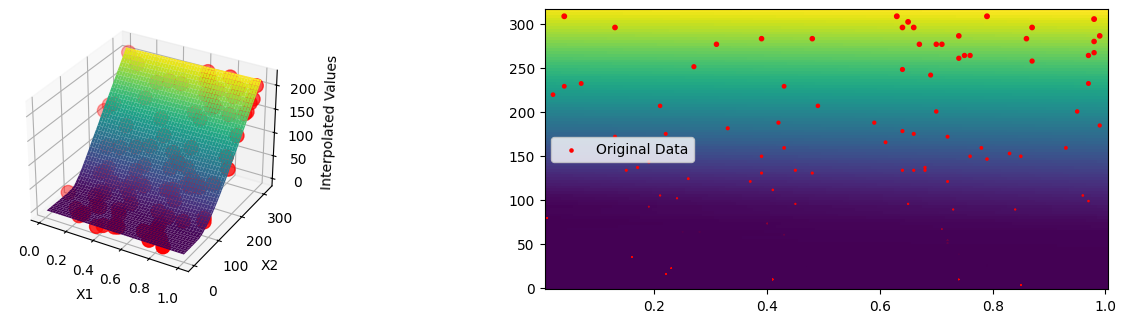

In [93]:
# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(TT, SS, rbf_values.reshape(SS.shape), cmap='viridis')

# Plot the original data points
ax.scatter(sub_TT,sub_SS, sub_call_prices, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')

ax2 = fig.add_subplot(222)
ax2.pcolormesh(T,S,  rbf_values.reshape(SS.shape).T)
ax2.scatter(sub_X[:, 1], sub_X[:, 0] , s=sub_call_prices/20, c='red', label='Original Data')
ax2 = plt.gca()



# ax4 = fig.add_subplot(224)
# ax4.pcolormesh(T, S, rbf_cal.T)
# ax4= plt.gca()

print('Error for rbf derivation')
print(relative_squared_error(call_prices.flatten(),rbf_values))


plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error for rbf derivation
0.022715995718700106


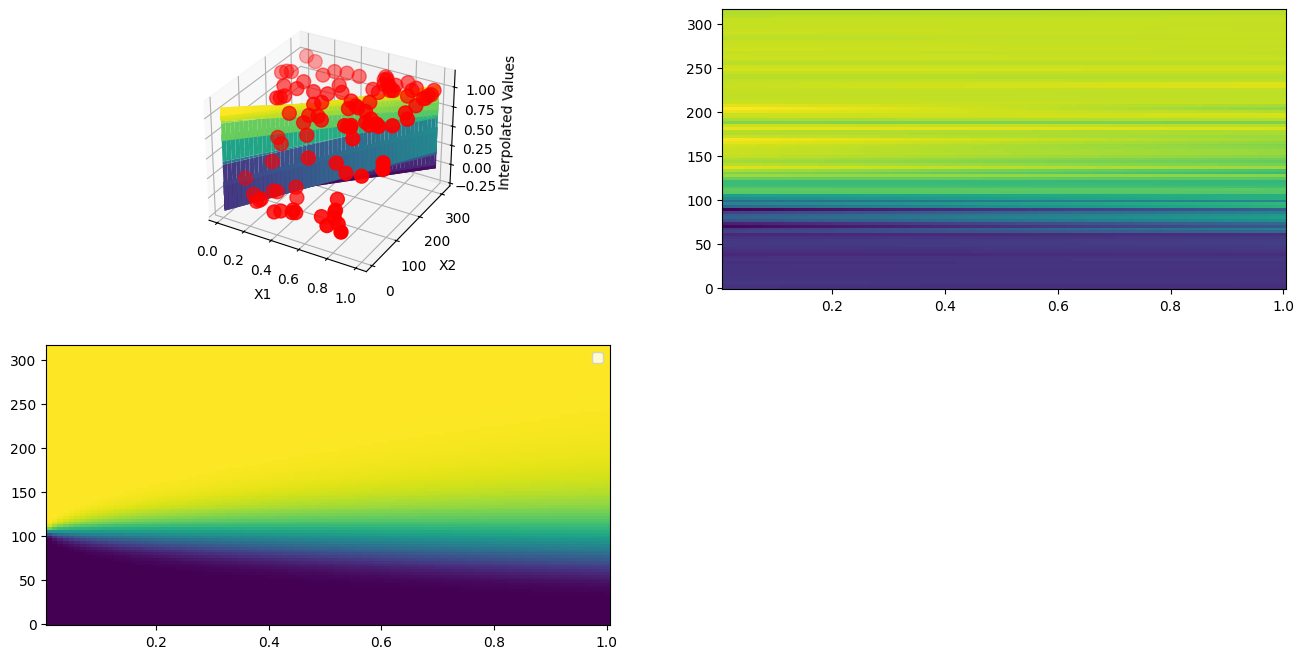

In [94]:
# numerical_derivative_interpolated = ps.FiniteDifference(axis=0,order = 2)._differentiate(rbf_values,t = np.ravel(S))

# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(T, S, rbf_values_x.reshape(SS.shape).T, cmap='viridis')

# Plot the original data points
ax.scatter(sub_X[:, 1], sub_X[:, 0], sub_deltas, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')


ax2 = fig.add_subplot(222)
ax2.pcolormesh(T, S,  rbf_values_x.reshape(SS.shape).T)
ax2 = plt.gca()

ax3 = fig.add_subplot(223)
ax3.pcolormesh(T, S, deltas.T)
ax3= plt.gca()


print('Error for rbf derivation')
print(relative_squared_error(deltas.flatten(),rbf_values_x))
plt.legend()
plt.show()




No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Error for rbf derivation
9.128968962831882


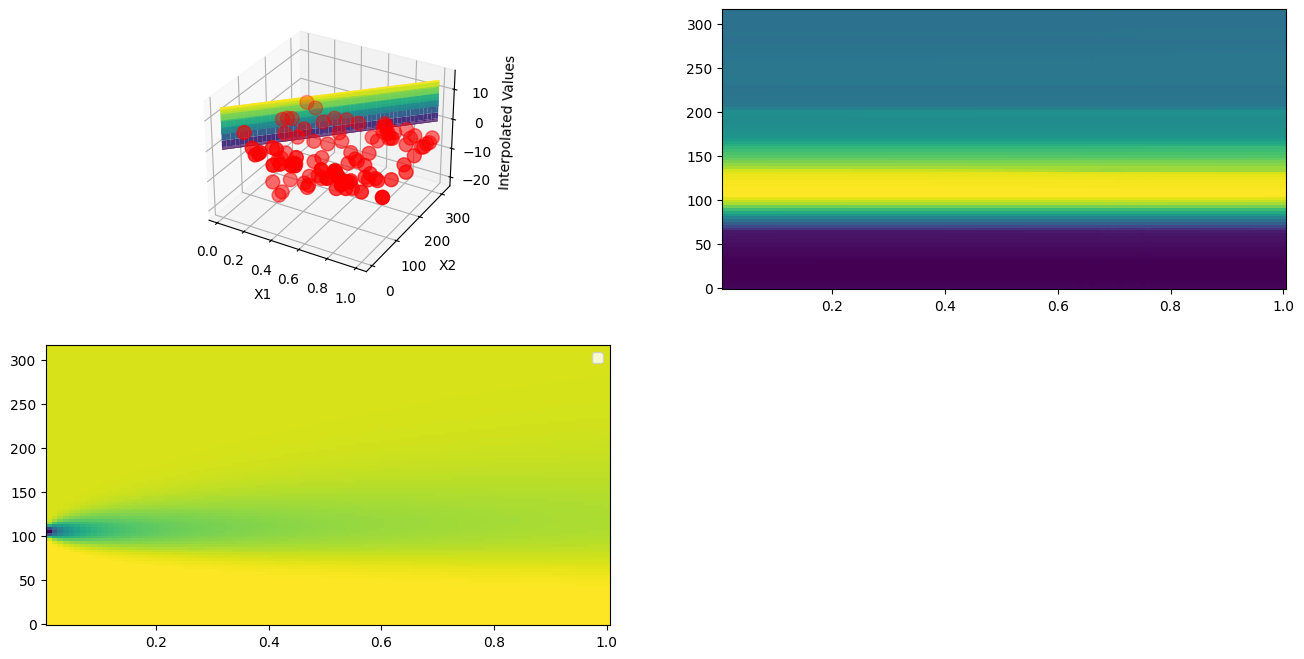

In [95]:
# Plot the interpolated surface
fig = plt.figure(figsize=[16,8])
ax = fig.add_subplot(221, projection='3d')
ax.plot_surface(T, S, rbf_values_t.reshape(SS.shape).T, cmap='viridis')
# Plot the original data points
ax.scatter(sub_X[:, 1], sub_X[:, 0], sub_theta, c='red', s=100, label='Original Data')

ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Interpolated Values')


ax2 = fig.add_subplot(222)
ax2.pcolormesh(T, S,  rbf_values_t.reshape(SS.shape).T)

ax3 = fig.add_subplot(223)
ax3.pcolormesh(T, S, theta.T)
ax3= plt.gca()

print('Error for rbf derivation')
print(relative_squared_error(theta.flatten(),rbf_values_t))
plt.legend()
plt.show()




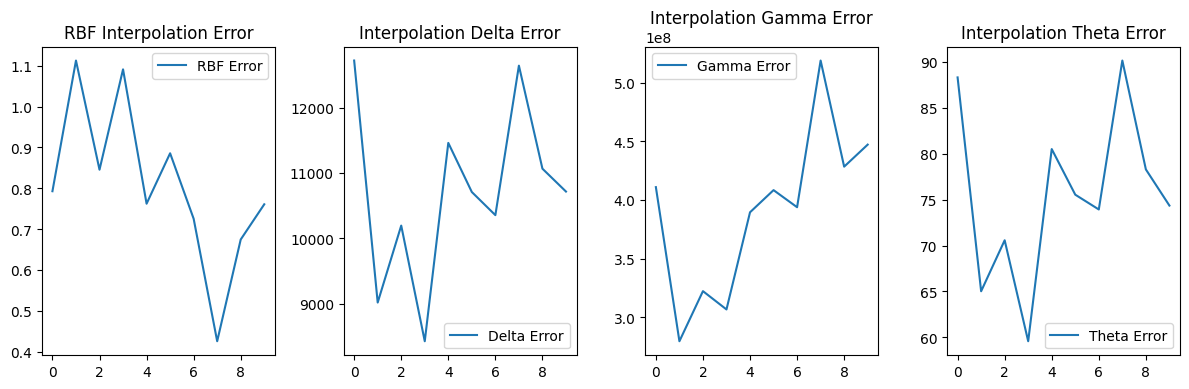

In [97]:
num_runs = 10
errors_rbf = []
errors_delta = []
errors_gamma = []
errors_theta = []

for _ in range(num_runs):

    # Subsample the grid to create a less dense grid for interpolation
    indices = np.random.choice(np.arange(len(S) * len(T)), size=int(len(T)), replace=True)
    sub_SS = SS.flatten()[indices]
    sub_TT = TT.flatten()[indices]
    sub_X = np.array([list(a) for a in zip(sub_SS,sub_TT)])
    sub_call_prices = call_prices.flatten()[indices]

    rbf_values,rbf_values_x,rbf_values_xx,rbf_values_t,_ = RBFN_2d(sub_X, sub_call_prices,gaussian_rbf())(S,T)
    # Calculate errors
    error_rbf = relative_squared_error(call_prices.flatten(), rbf_values) 
    error_delta = relative_squared_error(deltas.flatten(),rbf_values_x)
    error_gamma = relative_squared_error(gammas.flatten(),rbf_values_xx)
    error_theta = relative_squared_error(theta.flatten(),rbf_values_t)

    errors_rbf.append(error_rbf)
    errors_delta.append(error_delta)
    errors_gamma.append(error_gamma)
    errors_theta.append(error_theta)



# Plot errors
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
plt.plot(errors_rbf, label='RBF Error')
plt.title('RBF Interpolation Error')
plt.legend()

plt.subplot(1, 4, 2)
plt.plot(errors_delta, label='Delta Error')
# plt.plot(errors_delta_n, label='Delta Numerical Error')
plt.title('Interpolation Delta Error')

plt.legend()

plt.subplot(1, 4, 3)
plt.plot(errors_gamma, label='Gamma Error')
# plt.plot(errors_gamma_n, label='Gamma Numerical Error')
plt.title('Interpolation Gamma Error')
plt.legend()

plt.subplot(1, 4, 4)
plt.plot(errors_theta, label='Theta Error')
# plt.plot(errors_theta_n, label='Theta Numerical Error')

plt.title('Interpolation Theta Error')
plt.legend()

plt.tight_layout()
plt.show()


In [103]:
# Interpolate the surface
rbf_values,rbf_values_x,rbf_values_xx,rbf_values_t,_ = RBFN_2d(sub_X, sub_call_prices,cubic_rbf())(S,T)

Theta = np.array([sub_SS.flatten(),sub_SS.flatten()**2,rbf_values.flatten()[indices],rbf_values_x.flatten()[indices],rbf_values_xx.flatten()[indices]]).T

Crossed_Theta,Theta_names = build_cross_library(Theta,['x','x^2','u','u_x','u_xx'])

optimizer = ps.STLSQ(threshold=1e-2, alpha=8e2).fit(Crossed_Theta,rbf_values_t.flatten()[indices])

print_model(optimizer.coef_[0],Theta_names,precision=5)

new_coef = threshold_remove(Crossed_Theta,optimizer.coef_[0],rbf_values_t.flatten()[indices],threshold=0.01)

print_model(new_coef,Theta_names,precision=5)


d:\FACULDADE\bs-find-with-sindy\src\utils\interpol_utils.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficients, _, _, _ = np.linalg.lstsq(RBF_matrix, Y)


u_t = + 0.07773 x + 0.05134 u + 0.04416 x*u_x + -0.21629 u*u_x
u_t = + 0.0611 x + 0.17903 u + 0.0628 x*u_x + -0.34761 u*u_x


In [99]:
# Interpolate the surface
rbf_values,rbf_values_x,rbf_values_xx,rbf_values_t,_ = RBFN_2d(sub_X, sub_call_prices,cubic_rbf())(S,T)

Theta = np.array([SS.flatten(),SS.flatten()**2,rbf_values.flatten(),rbf_values_x.flatten(),rbf_values_xx.flatten()]).T

Crossed_Theta,Theta_names = build_cross_library(Theta,['x','x^2','u','u_x','u_xx'])

optimizer = ps.STLSQ(threshold=3e-2, alpha=3e4).fit(Crossed_Theta,rbf_values_t.flatten())

print_model(optimizer.coef_[0],Theta_names,precision=5)

new_coef = threshold_remove(Crossed_Theta,optimizer.coef_[0],rbf_values_t.flatten(),threshold=0.01)

print_model(new_coef,Theta_names,precision=5)


d:\FACULDADE\bs-find-with-sindy\src\utils\interpol_utils.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  coefficients, _, _, _ = np.linalg.lstsq(RBF_matrix, Y)


u_t = + 0.07854 x + 0.06305 u + 0.04637 x*u_x + -0.23477 u*u_x
u_t = + 0.07206 x + 0.12802 u + 0.05355 x*u_x + -0.30114 u*u_x


In [131]:
print('----------------------------Weak Formulation--------------------------------')


library_functions = [lambda x: x, lambda x: x * x,lambda x: SS.T,lambda x: SS.T**2]
library_function_names = [lambda x: x,lambda x: x + '*' + x,lambda x: 'x',lambda x: 'x**2']

pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=ST,
    is_uniform=True,
    periodic=False,
    p = 8,
    differentiation_method = ps.SmoothedFiniteDifference,
    K=500,
)

optimizer = ps.STLSQ(threshold=1e-2, alpha=1e2)

model = ps.SINDy(feature_names = ['u'],feature_library=pde_lib, optimizer=optimizer)
model.fit(rbf_values_reshaped.reshape(100,100,1))
model.print()

----------------------------Weak Formulation--------------------------------
(u)' = 0.653 u + 0.057 x + -0.803 uu_1 + 0.051 xu_1


In [ ]:
Theta = np.stack([sub_SS.flatten(),sub_SS.flatten()**2,rbf_values.flatten()[indices],rbf_values_x.flatten()[indices],rbf_values_xx.flatten()[indices]])
Crossed_Theta,Theta_names = build_cross_library(Theta,['x','x^2','u','u_x','u_xx'])


print('----------------------------Ensemble method----------------------------')
optimizer = ps.STLSQ(threshold=1e-3, alpha=2e2)
# optimizer = ps.SR3(threshold=0.01,nu = .1 , max_iter=1000, tol=1e-10,thresholder='l1')
# optimizer = ps.SSR(alpha=.1,kappa = .001,)

model = ps.SINDy(feature_library=ps.IdentityLibrary, optimizer=optimizer)
model.fit(Crossed_Theta, x_dot = rbf_values_t,
        library_ensemble =False,
        ensemble = True,
        n_candidates_to_drop=5,
        n_models = 300,
        n_subset = len(T) //2,
        quiet=True)
library_ensemble_coefs = model.coef_list

mean_ensemble = np.mean(library_ensemble_coefs,axis=0)[0]
median_ensemble = np.median(library_ensemble_coefs,axis=0)[0]

print('Mean:')
print_model(mean_ensemble,lib.get_feature_names(),precision=3)
print('Median:')
print_model(median_ensemble,lib.get_feature_names(),precision=3)
#Fit the data using ensemble methos on the finite difference values

optimizer.coef_ = median_ensemble
pred = lib_tr @ median_ensemble

print('\nMean threshold remove \n')
#Remove less participative terms
new_coef = threshold_remove(lib_tr,median_ensemble,target = u_t,threshold = 0.05,axis=2)
pred = lib_tr[:,:-1,:] @ new_coef
print_model(new_coef,lib.get_feature_names())